In [1]:
import matplotlib.pyplot as plt
import os
import os.path
import math
import numpy as np
from collections import OrderedDict

In [2]:
def create_file_name(path, name, suffix):
    return os.path.join(path, name + suffix)

In [3]:
def read_lidar_times(frame_id):
    file_path = create_file_name("./lidar_recognition_1080", str(frame_id), "_seg.txt")
    if not os.path.exists(file_path):
        print("File path: {} does not exists.".format(file_path))
        return {}
    times = {}
    with open(file_path) as lidar_times_file:
        lines = lidar_times_file.readlines()
        for line in lines:
            components = line.strip().split()
            times[components[0]] = float(components[1])
    return times

In [4]:
def plot_lidar_times(times_list):
    average_times = {}
    std_dev_times = {}
    keys = times_list[0].keys()
    for key in keys:
        values = np.array([times[key] for times in times_list])
        average_times[key] = np.round(np.average(values), decimals=3)
        std_dev_times[key] = np.round(np.sqrt(np.var(values)), decimals=3)
        print("{} - {} - {}".format(key, average_times[key], std_dev_times[key]))
    average_response_time = np.round(np.sum([average_times[key] for key in keys]), decimals=3)
    legend_names = []
    legend_bars = []
    figure, axes = plt.subplots(figsize=(20,10))
    reversed_keys = list(keys)
    bottoms = np.zeros(len(times_list))
    zero = 0
    for key in reversed_keys:
        if average_times[key] > 1:
            legend_names.append(key)
            values = [times[key] for times in times_list]
            legend_bars.append(axes.bar(np.arange(len(values)), values, width=0.5, bottom=bottoms))
            bottoms = values
    for key in legend_names:
        axes.plot([0, len(times_list) - 1], [average_times[key] + zero, average_times[key] + zero], color='black')
        zero += average_times[key]
    axes.set_ylabel("Step Times [ms]")
    axes.set_xticks(np.arange(len(times_list), int(math.sqrt(len(times_list)))))
    axes.set_title("Lidar Segmentation {} ms".format(average_response_time))
    new_legend_names = []
    for key in legend_names:
        new_legend_names.append(key + " {} ms".format(average_times[key]))
    axes.legend(legend_bars, new_legend_names)
    plt.savefig("lidar.svg")

In [11]:
def read_recognition_respose_times():
    file_path = create_file_name("./lidar_recognition_1080", "recognition.log", "")
    if not os.path.exists(file_path):
        print("File path: {} does not exists.".format(file_path))
        return {}
    response_times = []
    with open(file_path) as lidar_log_file:
        lines = lidar_log_file.readlines()
        response_times_lines = [line for line in lines if "Response time" in line]
        response_times = [float(line.strip().split()[-1]) for line in response_times_lines]
        lidar_obstacles_lines = [line for line in lines if "Lidar obstacles" in line]
        lidar_obstacles = [int(line.strip().split()[-1]) for line in lidar_obstacles_lines]
        return response_times, lidar_obstacles

In [15]:
def plot_recognition_response_times(response_times, lidar_obstacles):
    average_recognition_response_time = np.round(np.average(np.array(response_times)), decimals=2)
    std_dev_response_time = np.round(np.sqrt(np.var(np.array(response_times))), decimals=2)
    print("{} - {} - {}".format("Recognition", average_recognition_response_time, std_dev_response_time))
    figure, axes = plt.subplots(figsize=(20,10))
    axes.bar(np.arange(len(response_times)), response_times, width=0.5)
    axes.plot([0, len(response_times) - 1], [average_recognition_response_time, average_recognition_response_time], color="black")
    axes.set_ylabel("Response Times [ms]")
    axes.set_title("Recognition {} ms".format(average_recognition_response_time))
    axes2 = axes.twinx()
    axes2.plot(range(len(lidar_obstacles)), lidar_obstacles, "o", color="red")
    axes2.set_ylabel("Lidar Obstacles")
    plt.savefig("recognition.svg")

In [19]:
def read_lidar_tracking_log():
    file_path = "./lidar_recognition_1080/lidar_tracking.log.info"
    tracking = []
    classifier = []
    with open(file_path) as ltlog_file:
        lines = ltlog_file.readlines()
        lines = [line for line in lines if "Lidar" in line]
        for i in range(0, len(lines), 2):
            tracking.append(float(lines[i].strip().split()[-1]))
            classifier.append(float(lines[i + 1].strip().split()[-1]))
        mean_tracking = np.round(np.mean(np.array(tracking)), decimals=3)
        std_tracking = np.round(np.std(np.array(tracking)), decimals=3)
        mean_classifier = np.round(np.mean(np.array(classifier)), decimals=3)
        std_classifier = np.round(np.std(np.array(classifier)), decimals=3)
        print("{} - {} - {}".format("Tracking", mean_tracking, std_tracking))
        print("{} - {} - {}".format("Classifier", mean_classifier, std_classifier))
        return tracking, classifier

In [49]:
def plot_lidar_tracking(lidar_tracking, lidar_classifier, lidar_obstacles):
    figure, axes1 = plt.subplots(figsize=(20,10))
    b1 = axes1.bar(range(len(lidar_tracking)), lidar_tracking, width=0.5)
    b2 = axes1.bar(range(len(lidar_classifier)), lidar_classifier, width=0.5, bottom=lidar_tracking)
    axes1.set_ylabel("Step Times [ms]")
    axes1.set_title("Lidar Tracking {} ms".format(np.round(np.mean(np.array(lidar_tracking) + np.array(lidar_classifier)), decimals=3)))
    axes1.legend([b1, b2], ["Tracking", "Classification"])
    axes2 = axes1.twinx()
    axes2.plot(range(len(lidar_obstacles)), lidar_obstacles, "o", color="red")
    axes2.set_ylabel("Lidar Obstacles")
    plt.savefig("lidat_tracking.svg")

In [50]:
def main():
    if not os.path.exists("./lidar_recognition_1080"):
        print("The debug_output folder must exist!")
        return
    lidar_times_count = len([f for f in os.listdir("./lidar_recognition_1080") if f.endswith("seg.txt")])
    times_list = []
    for i in range(1, lidar_times_count + 1):
        times = read_lidar_times(i)
        times_list.append(times)

    recognition_response_times, lidar_obstacles = read_recognition_respose_times()
    lidar_tracking, lidar_classifier = read_lidar_tracking_log()
    plot_lidar_times(times_list)
    plot_recognition_response_times(recognition_response_times, lidar_obstacles)
    plot_lidar_tracking(lidar_tracking, lidar_classifier, lidar_obstacles)

Tracking - 1.643 - 1.113
Classifier - 0.014 - 0.008
CloudPreprocessor::Preprocess: - 10.009 - 5.716
Segmentor::Segment: - 23.616 - 3.163
ObjectFilter::Filter: - 0.014 - 0.005
ObjectBuilder::Build: - 0.687 - 1.528
MapManager::Update: - 0.0 - 0.0
Recognition - 1.72 - 1.13


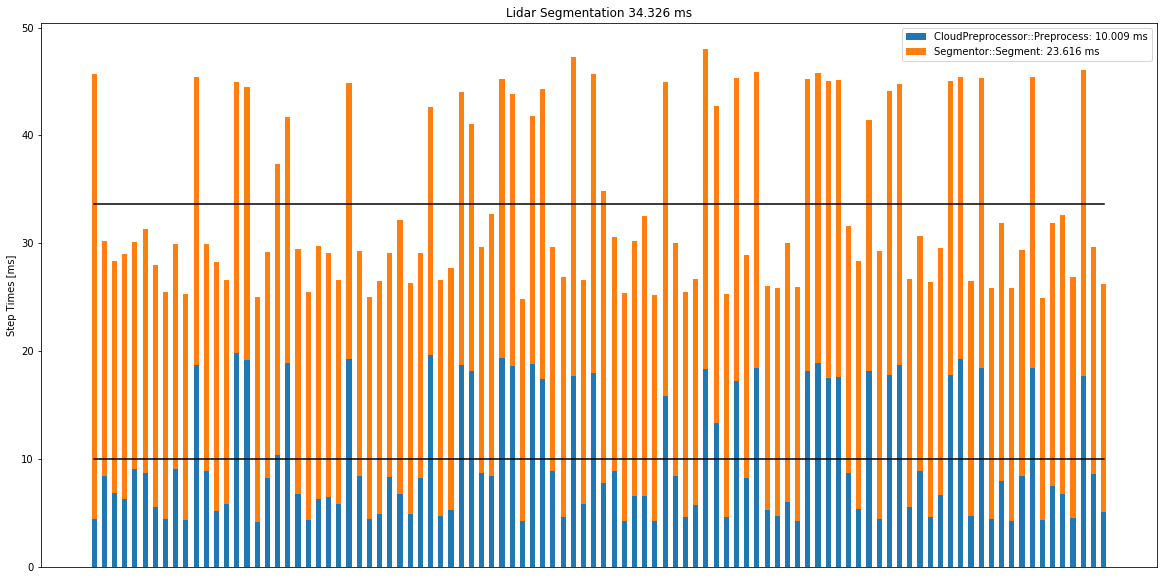

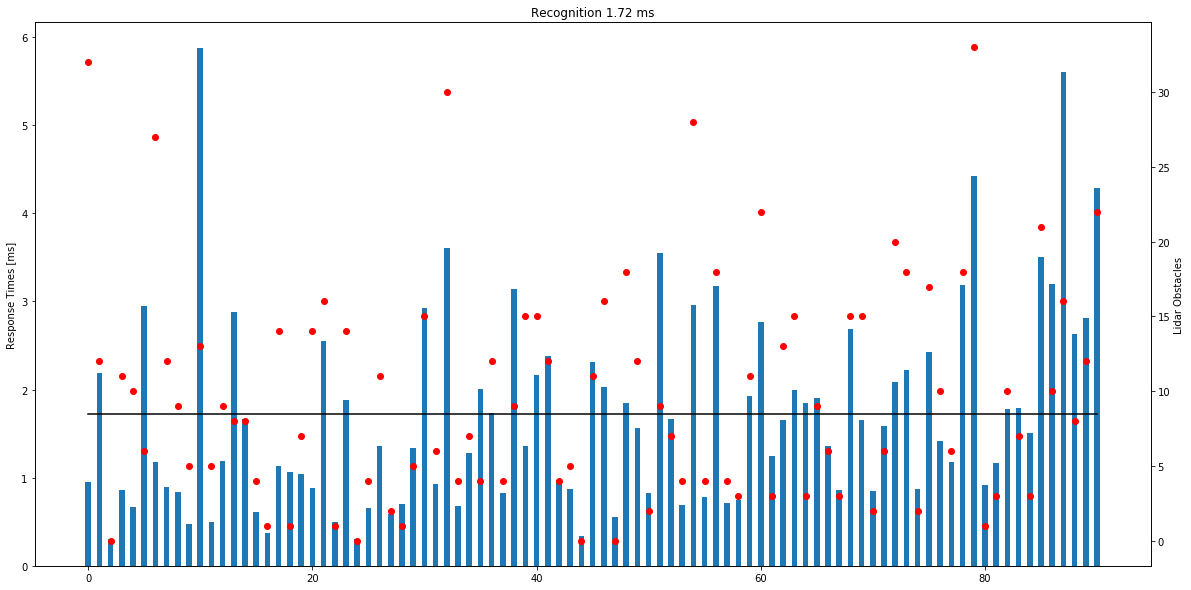

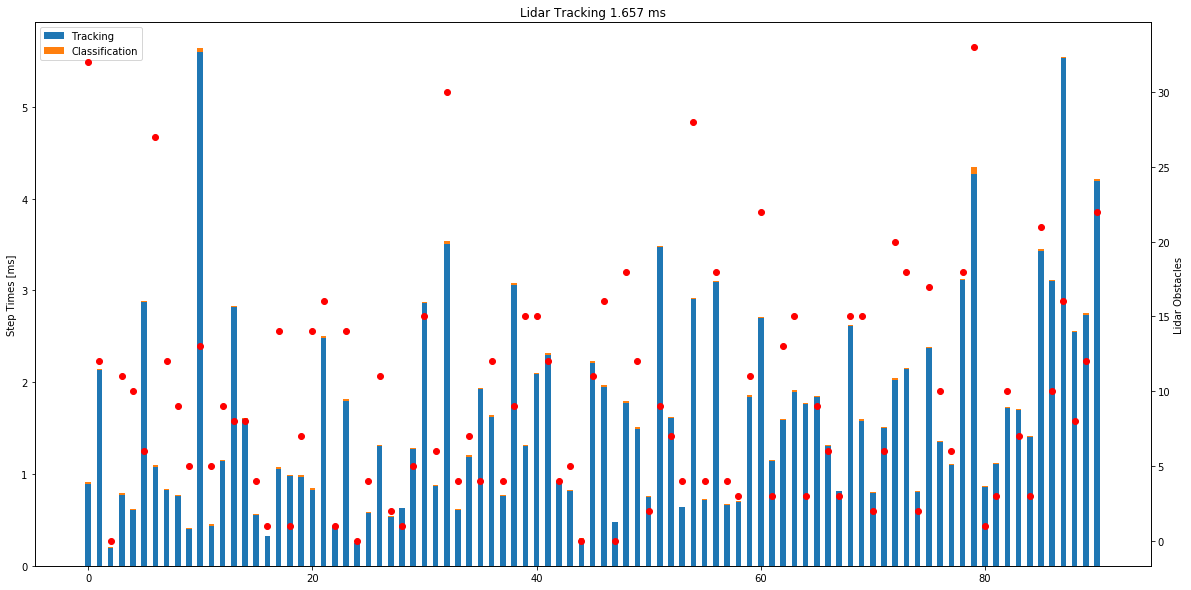

In [51]:
main()

In [9]:
def read_preprocessor_stats():
    file_path = "./lidar_recognition_1080/preprocessor.log"
    with open(file_path) as pre_log_file:
        lines = pre_log_file.readlines()
        lines = lines[3:]
        stats = []
        for i in range(0, len(lines), 4):
            ptr_check_time = float(lines[i].strip().split()[-1])
            filter_time = float(lines[i + 1].strip().split()[-1])
            transform_time = float(lines[i + 2].strip().split()[-1])
            begin = int(lines[i + 3].strip().split()[-3])
            end = int(lines[i + 3].strip().split()[-1])
            stats.append((ptr_check_time, filter_time, transform_time, begin, end))
        avg_ptr_check_time = np.round(np.mean(np.array([s[0] for s in stats])), decimals=3)
        avg_filter_time = np.round(np.mean(np.array([s[1] for s in stats])), decimals=3)
        avg_transform_time = np.round(np.mean(np.array([s[2] for s in stats])), decimals=3)
        avg_point_loss = np.round(np.mean(np.array([s[4] - s[3] for s in stats])), decimals=3)
        std_ptr_check_time = np.round(np.std(np.array([s[0] for s in stats])), decimals=3)
        std_filter_time = np.round(np.std(np.array([s[1] for s in stats])), decimals=3)
        std_transform_time = np.round(np.std(np.array([s[2] for s in stats])), decimals=3)
        std_point_loss = np.round(np.std(np.array([s[4] - s[3] for s in stats])), decimals=3)
        print("{} - {} - {}".format("Ptr Check", avg_ptr_check_time, std_ptr_check_time))
        print("{} - {} - {}".format("Filter", avg_filter_time, std_filter_time))
        print("{} - {} - {}".format("Transform", avg_transform_time, std_transform_time))
        print("{} - {} - {}".format("Point Loss", avg_point_loss, std_point_loss))

read_preprocessor_stats()

Ptr Check - 0.001 - 0.001
Filter - 8.775 - 5.462
Transform - 0.533 - 0.367
Point Loss - 0.0 - 0.0


In [10]:
def read_segmentation_stats():
    file_path = "./lidar_recognition_1080/segmentation.log"
    stats = OrderedDict()
    stats["RoiFilter"] = []
    stats["GroundDetector"] = []
    stats["Mapping"] = []
    stats["Feature"] = []
    stats["Inference"] = []
    stats["ForegroundSegmentation"] = []
    stats["Join"] = []
    stats["Collect"] = []
    avg_stats = OrderedDict()
    with open(file_path) as seg_log_file:
        lines = seg_log_file.readlines()
        lines = [line for line in lines if "Ground-detector" in line or "CNNSEG" in line]
        for i in range(0, len(lines), 2):
            stats["RoiFilter"].append(float(lines[i].strip().split()[-4]))
            stats["GroundDetector"].append(float(lines[i].strip().split()[-1]))
            components = lines[i + 1].strip().split()
            stats["Mapping"].append(float(components[-11]))
            stats["Feature"].append(float(components[-9]))
            stats["Inference"].append(float(components[-7]))
            stats["ForegroundSegmentation"].append(float(components[-5]))
            stats["Join"].append(float(components[-3]))
            stats["Collect"].append(float(components[-1]))
    for key in stats.keys():
        mean = np.round(np.mean(np.array(stats[key])), decimals=3)
        std = np.round(np.std(np.array(stats[key])), decimals=3)
        avg_stats[key] = [mean, std]
        print("{} - {} - {}".format(key, mean, std))
        
read_segmentation_stats()

RoiFilter - 0.341 - 0.182
GroundDetector - 1.415 - 0.841
Mapping - 0.173 - 0.134
Feature - 0.246 - 0.07
Inference - 11.413 - 1.051
ForegroundSegmentation - 8.945 - 2.025
Join - 0.0 - 0.0
Collect - 0.363 - 0.229


Split - 0.085 - 0.079
Matching - 0.684 - 0.541
TrackingState - 0.505 - 0.592
CollectTracking - 0.316 - 0.144
Stale - 0.009 - 0.004


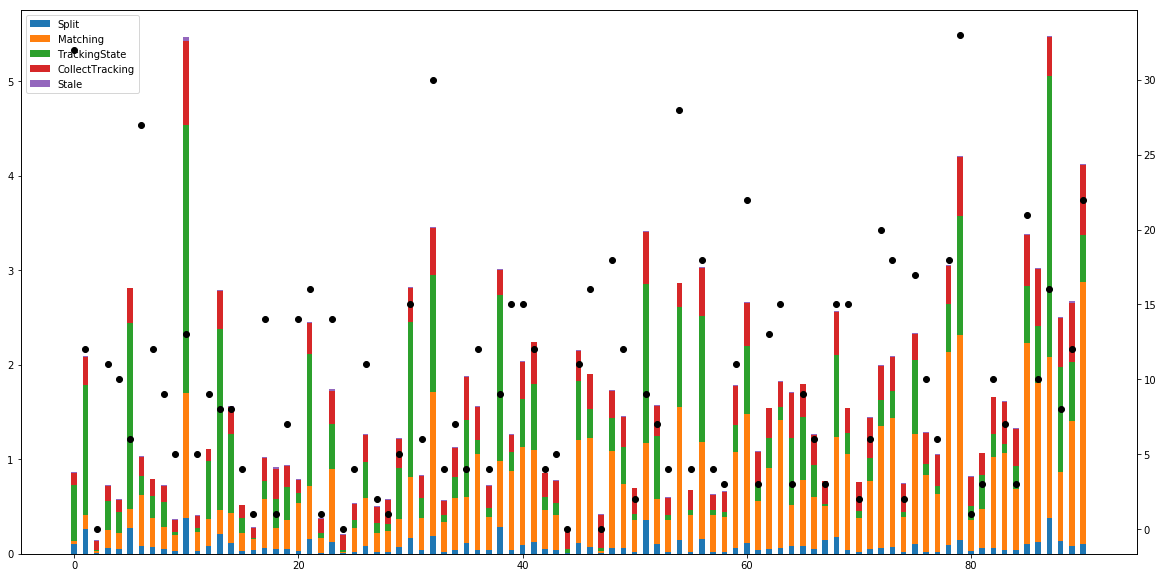

In [44]:
def print_mean_std(values, name):
    mean = np.round(np.mean(np.array(values)), decimals=3)
    std = np.round(np.std(np.array(values)), decimals=3)
    print("{} - {} - {}".format(name, mean, std))

def read_tracker_log():
    file_path = "./lidar_recognition_1080/tracker.log"
    keys = ["Split", "Matching", "TrackingState", "CollectTracking", "Stale"]
    logs = OrderedDict()
    with open(file_path) as tracker_log_file:
        lines = tracker_log_file.readlines()
        logs["Split"] = [float(line.strip().split()[-1]) for line in lines if "Split" in line]
        logs["Matching"] = [float(line.strip().split()[-1]) for line in lines if "Matching" in line]
        logs["TrackingState"] = [float(line.strip().split()[-1]) for line in lines if "TrackingState" in line]
        logs["CollectTracking"] = [float(line.strip().split()[-1]) for line in lines if "CollectTracking" in line]
        logs["Stale"] = [float(line.strip().split()[-1]) for line in lines if "Stale" in line]
    for key in keys:
        print_mean_std(logs[key], key)
    return logs

def plot_tracker_log(logs, lidar_obstacles):
    count = len(logs[list(logs.keys())[0]])
    bottom = np.zeros(count)
    figure, axes1 = plt.subplots(figsize=(20,10))
    bars = []
    legend_names = []
    for key in logs.keys():
        bars.append(axes1.bar(range(count), logs[key], width=0.5, bottom=bottom))
        legend_names += [key]
        bottom += np.array(logs[key])
    axes1.legend(bars, legend_names)
    axes2 = axes1.twinx()
    axes2.plot(range(count), lidar_obstacles, "o", color="black")
    plt.show()
    
_, lidar_obstacles = read_recognition_respose_times()
logs = read_tracker_log()
plot_tracker_log(logs, lidar_obstacles)